# Recyclable Solid Waste Image Classification
-- Rebuilding our world from trash -- 

## Background
Indonesia is one of the biggest contributors to plastic waste in the world. This is also getting worse every year, due to the lack of awareness of the Indonesian people about the waste problem, resulting in massive waste accumulation. Indonesia produces almost 64 million tons of plastic waste every year, 3.2 million tons are plastic waste that is dumped into the sea, and only about a fourth of that is ever recycled. 

In Indonesia, recycling is not achieving its full potential, not even close. As a developing country, Indonesia does not have adequate waste management and recycling infrastructure. Thousands of wastepickers and workers are sorting our waste every day to keep our oceans clean and our landfills empty. Improper waste management can generate more GHGs. 

44% production of Greenhouse Gases (GHGs) comes from our products and packaging so that means, it represents the largest portion of what we're creating, but it also means that it represents the largest portion of what we can do to reduce greenhouse gas consumption. That's an opportunity for us to save energy and save greenhouse gases.

Recycling become a bigger part of how waste is managed, we can find  over 90% of products and packaging material is recoverable in some form or another. All of that stuff sorted out so that they can turn it into new things. No plastic cannot be recycled, all of it can be reused.

So what's the missing step between worthless garbage and valuable commodity? Sorting. But, Indonesia's effort to manage its waste has been hampered with a basic problem for years now: all of its garbage remains unsorted. That's our biggest challenge, how we sort our waste. 


## Solution
Use machine learning and artificial intelligence to solve some of the primary challenges of the recycling process. ML and AI that can learn to identify all of the different materials in the waste stream. Some of them says It's going to be too difficult. The trash is always messed up in some way, it's being torn, crushed, dirty, and each object looks different.

Basically it's just how we train data sets using examples of the real material, and train an AI to recognize them, so that computer systems be able to identify inconsistent items.

By developing AI and Machine Learning that teachs systems to identify all of these different materials whether they're bottles cans whether they're smashed up.

This program shows simple machine learning and artificial intelligence to classify images for sorting of Recyclable Solid Waste (Plastic, Metal, and Glass) using a *tf.keras.Sequential* model and load data using *tf.keras.utils.image_dataset_from_directory.* 

This notebooks follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process


## Setup ML
Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Dataset
This notebook use a dataset of about 5000 photos of Recyclable Solid Waste (Metal, Glass, and Plastic) in 6 Different Background Color(Black, Orange, Light Green, Dark Green, Grey, and White). The dataset contains 6 sub-directories, and three classes: 
1. Metal
2. Glass
3. Plastic

https://www.kaggle.com/datasets/hseyinsaidkoca/recyclable-solid-waste-dataset-on-5-background-co

I've merged the dataset from 6 different background into one folder for build machine learning, and separate them or take subset of the dataset as a sample dataset for future prediction.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# melakukan ekstraksi pada file zip
import zipfile,os
local_zip = '/content/drive/MyDrive/Dataset/Recycled/merge_recycled.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
# print list folder inside recyclable folder
print(os.listdir('/tmp/merge_recycled/'))
# set black folder sebagai root directory
data_dir = '/tmp/merge_recycled/'

['plastic', 'glass', 'metal']


In [5]:
import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file('black', origin=root_dir, untar=True)
data_dir = pathlib.Path(data_dir)

There are 4826 total images:

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4826


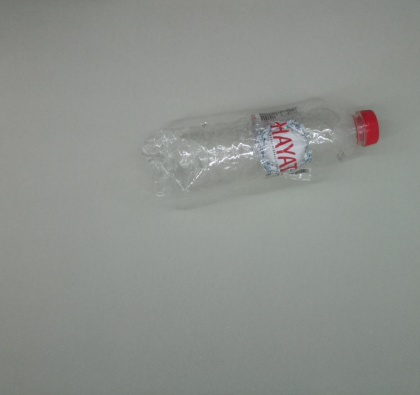

In [55]:
plastic = list(data_dir.glob('plastic/*'))
PIL.Image.open(str(plastic[5]))

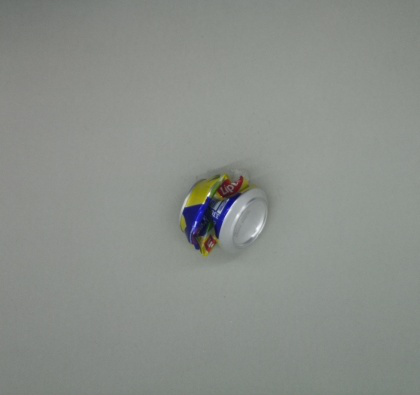

In [8]:
metal = list(data_dir.glob('metal/*'))
PIL.Image.open(str(metal[0]))

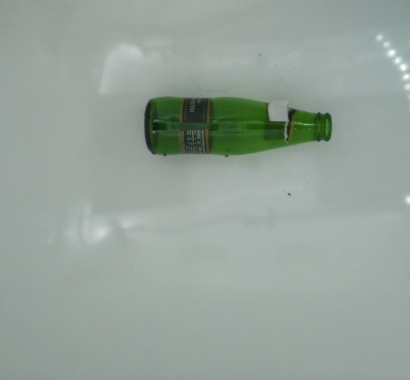

In [9]:
glass = list(data_dir.glob('glass/*'))
PIL.Image.open(str(glass[0]))

## Build and Input Pipeline

Load data using a Keras utility

Next, load images off disk using tf.keras.utils.image_dataset_from_directory utility. This will take a directory of images on disk to a tf.data.Dataset in just a couple lines of code.

### Create Dataset
Defining some parameters for the loader.

In [10]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. This notebook use 70% of the images for training and 30% for validation.

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4826 files belonging to 3 classes.
Using 3379 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4826 files belonging to 3 classes.
Using 1447 files for validation.


We can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [13]:
class_names = train_ds.class_names
print(class_names)

['glass', 'metal', 'plastic']


## Visualize the data
Here are the first nine images from the training dataset:

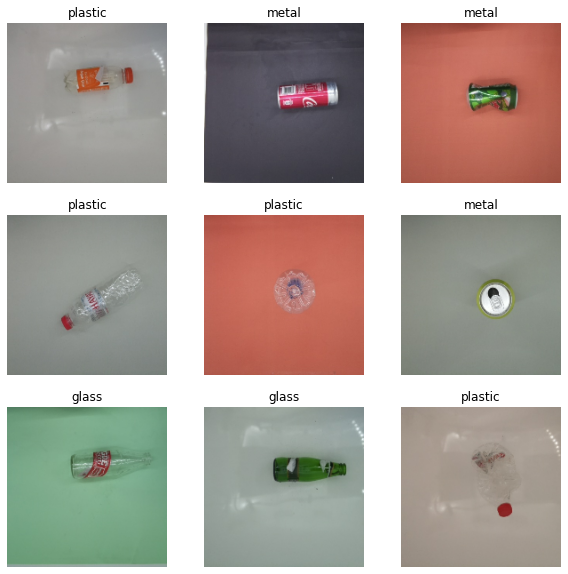

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## Build the model

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make our input values small.

Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [17]:
normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.119123764 0.9852929


## Data augmentation

To avoid overfitting, we used data augmentation. Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

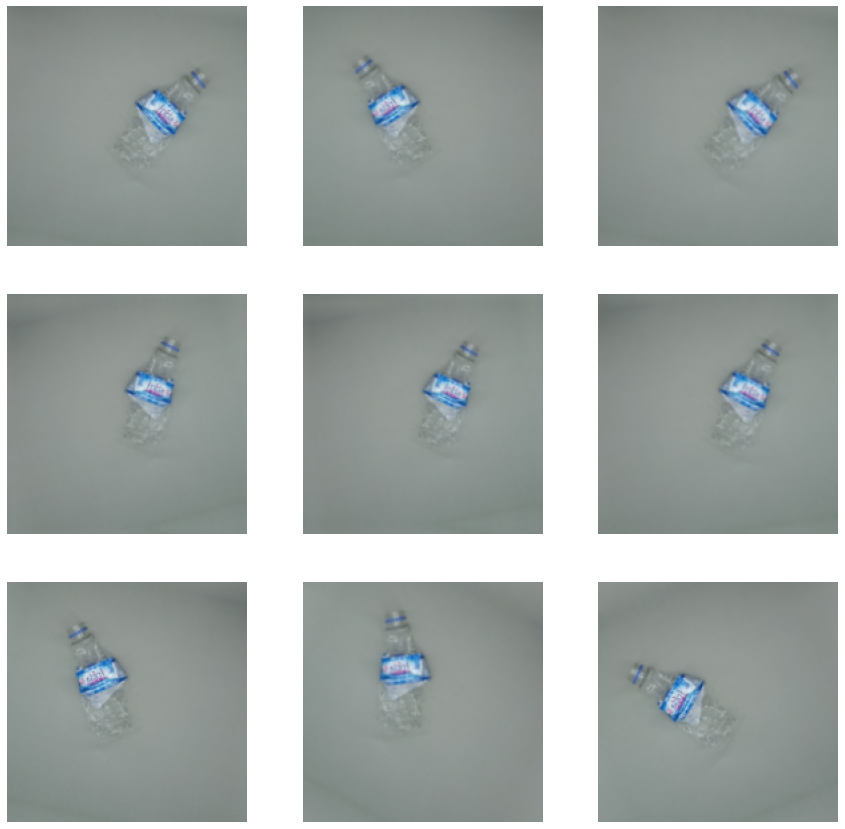

In [52]:
plt.figure(figsize=(15, 15))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## A basic Keras model
### Create the model
The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [21]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile the model
We choose the tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary
View all the layers of the network using the Keras Model.summary method:

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

Set Callbacks

In [24]:
# callbacks, stop epoch when accuracy meets spesific value
# Set the accuracy threshold
accuracy_threshold = 99e-2 # Accuracy 97%
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('accuracy') >= accuracy_threshold:
            print("\nReached %2.2f%% accuracy, training stopped" %(logs['accuracy']*100))
            self.model.stop_training = True

## Train the model
Train the model for 10 epochs with the Keras Model.fit method:

In [25]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[CustomCallback()] # callbacks
)

Epoch 1/10
106/106 [==============================] - 137s 1s/step - loss: 1.0715 - accuracy: 0.4342 - val_loss: 0.7259 - val_accuracy: 0.6593
Epoch 2/10
106/106 [==============================] - 137s 1s/step - loss: 0.5551 - accuracy: 0.7674 - val_loss: 0.5828 - val_accuracy: 0.7643
Epoch 3/10
106/106 [==============================] - 136s 1s/step - loss: 0.3943 - accuracy: 0.8417 - val_loss: 0.3309 - val_accuracy: 0.8625
Epoch 4/10
106/106 [==============================] - 133s 1s/step - loss: 0.3269 - accuracy: 0.8739 - val_loss: 0.2832 - val_accuracy: 0.8832
Epoch 5/10
106/106 [==============================] - 137s 1s/step - loss: 0.2913 - accuracy: 0.8790 - val_loss: 0.3587 - val_accuracy: 0.8569
Epoch 6/10
106/106 [==============================] - 131s 1s/step - loss: 0.2734 - accuracy: 0.8941 - val_loss: 0.3853 - val_accuracy: 0.8431
Epoch 7/10
106/106 [==============================] - 136s 1s/step - loss: 0.2275 - accuracy: 0.9130 - val_loss: 0.2513 - val_accuracy: 0.8894

## Visualize training results
Create plots of the loss and accuracy on the training and validation sets:

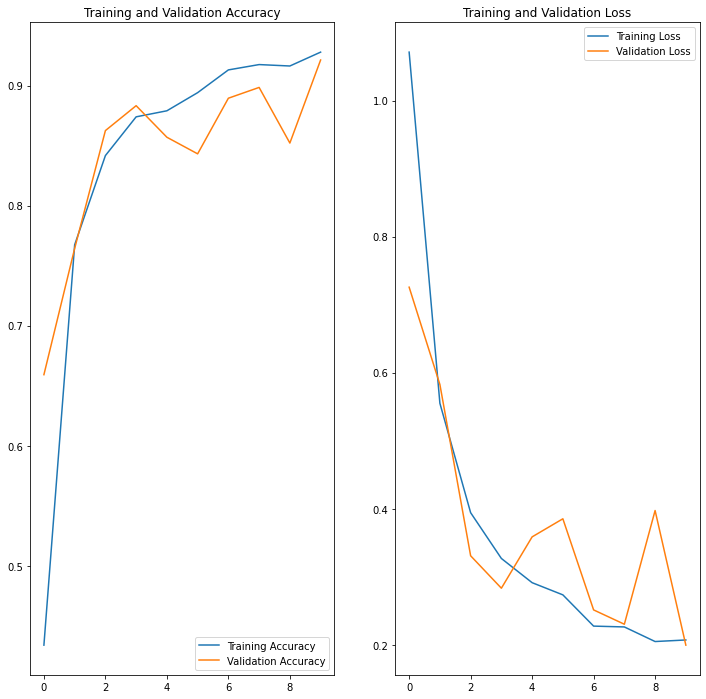

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data samples
Use our model to classify an image that wasn't included in the training or validation sets.

In [27]:
local_zip = '/content/drive/MyDrive/Dataset/Recycled/predict_recycled.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
print(os.listdir('/tmp/predict_recycled'))

['plastic', 'glass', 'metal']


In [28]:
img_predict = tf.keras.utils.image_dataset_from_directory(
  '/tmp/predict_recycled',
  image_size=(img_height, img_width))

Found 135 files belonging to 3 classes.


1/1 [==============================] - 0s 32ms/step


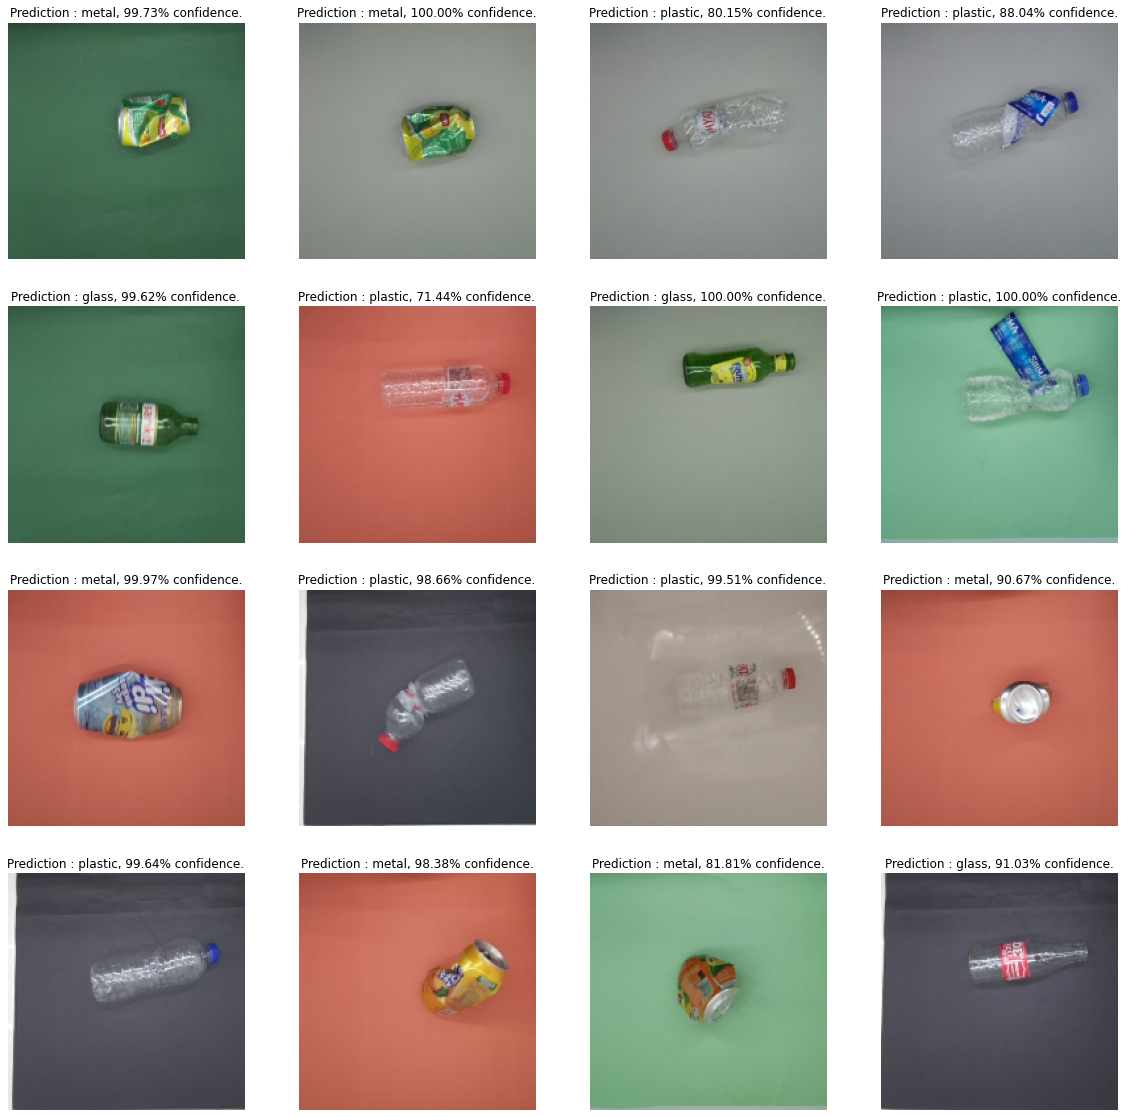

In [72]:
import numpy as np
from google.colab import files
import keras.utils as image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.figure(figsize=(20, 20))
#uploaded = files.upload()
for fn, labels in img_predict.take(1):
  for i in range(16):
#for fn in uploaded.keys():
  # predicting images
    img = fn[i].numpy().astype("uint8")

    #img = tf.keras.utils.load_img(path, target_size=(img_height, img_width))


    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(fn[i].numpy().astype("uint8"))
    #plt.title("Prediction: "+ class_names[np.argmax(score)] + r'Percent confidence: ' + 100 * np.max(score))
    plt.title("Prediction : {}, {:.2f}% confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score)))
    #plt.title('My Title\n' + r'$\alpha - \omega$ are LaTeX Markup')
    plt.axis("off")

    #print(fn)

With technology like this, it's not so crazy to imagine a world without landfills, a world where everything we use is put right back to use.